In [292]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import folium
from math import sin, cos, sqrt, atan2, radians
import random
import timeit

from scipy.spatial import cKDTree

# import geopy.distance

In [293]:
marburg = pd.read_pickle('../data/marburg_clean.pkl')
marburg_stations = pd.read_pickle('../data/stations/marburg_stations.pkl')

In [294]:
def calc_nearest_station(trips, stations):
    trips_arr = np.array(list(trips['dest']))
    stations_arr = np.array(list(stations['coordinates']))
    btree = cKDTree(stations_arr)
    # calculate k=1 nearest neighbor from stations for every trip
    dist, station_it_id = btree.query(trips_arr, k=1)
    
    return [dist, station_it_id]

In [295]:
marburg.insert(0, 'it_id', range(len(marburg)))
marburg_stations.insert(0,'it_id', range(len(marburg_stations)))

In [296]:
dist, station_it_id = calc_nearest_station(marburg, marburg_stations)
dist = pd.Series(dist)
station_it_id = pd.Series(station_it_id)
nearest_stations = pd.DataFrame({'near_station_dist_algo':dist, 'near_station_it_id':station_it_id})
nearest_stations.index.rename('trip_it_id', inplace=True)

In [297]:
# we create a dictionary containing the it_id as key and the real station id as value
it_id_to_station_id_dict = pd.Series(marburg_stations.index, index=marburg_stations['it_id']).to_dict()

nearest_stations['near_station_id'] = nearest_stations['near_station_it_id'].map(it_id_to_station_id_dict)

In [298]:
nearest_stations = nearest_stations.drop(['near_station_it_id'], axis=1)
marburg_stations = marburg_stations.drop(['it_id'], axis=1)

In [299]:
nearest_stations = nearest_stations.merge(right=marburg_stations, left_on='near_station_id', right_index=True)

In [300]:
nearest_stations.rename(columns={'coordinates':'near_station_coor'}, inplace=True)

In [301]:
nearest_stations

,near_station_dist_algo,near_station_id,near_station_coor
trip_it_id,,,
0,0.0,5166,"(50.811, 8.7742)"
23,0.0,5166,"(50.811, 8.7742)"
54,0.0,5166,"(50.811, 8.7742)"
59,0.0,5166,"(50.811, 8.7742)"
68,0.0,5166,"(50.811, 8.7742)"
...,...,...,...
162347,0.0,5157,"(50.8166, 8.7515)"
163219,0.0,5157,"(50.8166, 8.7515)"
163252,0.0,5157,"(50.8166, 8.7515)"


In [302]:
marburg = marburg.reset_index().merge(right=nearest_stations, how='outer', left_on='it_id', right_on='trip_it_id').set_index('datetime')

In [303]:
marburg = marburg.drop(['it_id'], axis=1)

In [304]:
marburg.head(3)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,near_station_dist_algo,near_station_id,near_station_coor
datetime,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,0.0,5166,"(50.811, 8.7742)"
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,0.0,5153,"(50.8058, 8.7828)"
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,0.0,5150,"(50.8229, 8.7747)"


In [305]:
# calculate distance betweeen two coordinates in km
def calc_dist(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [306]:
def calc_distances(row):
    dest_lat, dest_lon = row.dest
    stat_lat, stat_lon = row.near_station_coor
    # we multiply by 1000, because we want the distance in meters
    return calc_dist(dest_lat, dest_lon, stat_lat, stat_lon) * 1000

In [307]:
marburg['near_station_dist'] = marburg.apply(calc_distances, axis=1)

In [308]:
Ma_map = folium.Map(location=(50.81, 8.74), #took the middle of limits as coordinates
                       zoom_start=12, control_scale=True, max_zoom=20)
# Ma_map.add_child(plugins.HeatMap(marburg["orig"], radius=15)) #adding heatmap points with the cleaned orig coordinates
# Ma_map.add_child(plugins.HeatMap(marburg["dest"], radius=15)) #adding heatmap points with the cleaned dest coordinates
marburg_stations_list = list(marburg_stations['coordinates'])
positions = marburg_stations_list 
for position in positions:
    folium.CircleMarker(radius=5, location=position, 
                                 color='black', fill_color='black').add_to(Ma_map)
    
sample = marburg.sample()
positions = [*sample.dest.values, *sample.near_station_coor.values]
colors = ['red','green']
for i,position in enumerate(positions):
    folium.CircleMarker(radius=5, location=position, 
                                 color=colors[i], fill_color=colors[i]).add_to(Ma_map)
    
Ma_map

In [309]:
marburg['is_far'] = marburg['near_station_dist'].map(lambda dist : dist>300)
dist_near_station = marburg.drop(marburg.columns.difference(['near_station_dist','is_far']), 1)
dist_near_station

,near_station_dist,is_far
datetime,,
2019-07-04 13:29:00,0.00000,False
2019-07-06 16:53:00,0.00000,False
2019-07-06 17:18:00,0.00000,False
2019-07-06 20:11:00,0.00000,False
2019-07-07 08:47:00,0.00000,False
...,...,...
2019-05-19 12:57:00,0.00000,False
2019-05-19 21:41:00,0.00000,False
2019-05-20 06:56:00,0.00000,False


In [310]:
to_plot = dist_near_station[dist_near_station['is_far'] == True].resample('W').count()['is_far']

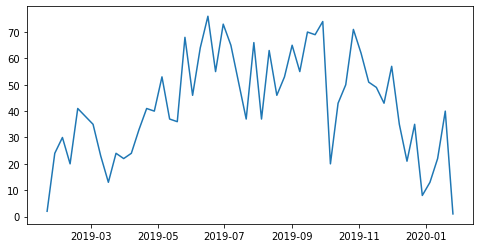

In [290]:

fig,ax = plt.subplots(figsize=(8,4))

ax.plot(to_plot)

plt.show()


In [291]:
to_plot.sum()

2290